# Prediction of  Groundcover under a Tree Canopy
  
  Imports and load the field data
  Calculate the gap probabilities through the woodland layers

In [122]:
## Imports
import numpy, time, datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats



# Function to convert a date to a timestamp
def datestr2num(s):
    return (datetime.datetime.strptime(s.decode('ascii'),'%d/%m/%Y') - datetime.datetime(1970, 1, 1)).total_seconds()

# Function to get the sensor number
def sensorNum(s):
    return float(s.decode('ascii')[1])


fname = 'fractionalChips20181204.csv'

# Load calibration data
interceptData = numpy.loadtxt(fname,skiprows=1,delimiter=",",usecols=(6,7,8,9,12,10,11,13,14,15,16,17,18,19,20,21))



nTotal = interceptData[:,14]
nUnoccluded = interceptData[:,15]
# Canopy Layer
nCanopyBranch = interceptData[:,13] * nTotal / 100.0
nCanopyDead = interceptData[:,12] * nTotal / 100.0
nCanopyGreen = interceptData[:,11] * nTotal / 100.0
nCrown = interceptData[:,10]
# Midstory Layer
nMidBranch = interceptData[:,9] * nTotal / 100.0
nMidGreen = interceptData[:,7] * nTotal / 100.0
nMidDead = interceptData[:,8] * nTotal / 100.0
# Ground Layer
nGroundDead = interceptData[:,5] * nUnoccluded / 100.0
nGroundLitter = interceptData[:,6] * nUnoccluded / 100.0
nGroundCrustDistRock = (interceptData[:,0] + interceptData[:,1] + interceptData[:,2]) * nUnoccluded / 100.0
nGroundGreen = interceptData[:,3] * nUnoccluded / 100.0
nGroundCrypto = interceptData[:,4] * nUnoccluded / 100.0
# Work out the canopy elements as viewed from above
canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
# Work out the midstorey fractions
midFoliageProjectiveCover = nMidGreen / nTotal
midDeadProjectiveCover = nMidDead / nTotal
midBranchProjectiveCover = nMidBranch / nTotal
midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
# Work out the midstorey  elements as viewed by the satellite using a gap fraction method
satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
satMidPlantProjectiveCover = midPlantProjectiveCover * (1 - canopyPlantProjectiveCover)
# Work out the groundcover fractions as seen by the observer
groundPVCover = nGroundGreen / nUnoccluded
groundNPVCover = (nGroundDead+nGroundLitter) / nUnoccluded
groundBareCover = nGroundCrustDistRock / nUnoccluded
groundCryptoCover = nGroundCrypto / nUnoccluded
groundTotalCover = (nGroundGreen + nGroundDead+nGroundLitter + nGroundCrustDistRock) / nUnoccluded
groundLitterFraction = nGroundLitter/(nGroundGreen + nGroundDead+nGroundLitter + nGroundCrustDistRock)
# Work out the ground cover propoetions as seen by the satellite
satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
satGroundTotalCover = groundTotalCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
# Final total covers calculated using gap probabilities through all layers
totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
totalNPVCover = canopyDeadProjectiveCover + canopyBranchProjectiveCover + satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover
totalBareCover = satGroundBareCover
totalCryptoCover = satGroundCryptoCover
# Work Out Persistent Fractions
satPersistentGreen=canopyFoliageProjectiveCover+satMidFoliageProjectiveCover
persistentNPVFraction=canopyDeadProjectiveCover+canopyBranchProjectiveCover+satMidDeadProjectiveCover+satMidBranchProjectiveCover

fractionalCoverArray =  numpy.transpose([totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction,groundLitterFraction])
    

# Load Reflectance Data
refData = numpy.loadtxt(fname,skiprows=1,delimiter=",",usecols=(26,27,28,29,30,31))/10000.0

# Load Metadata
metaData = numpy.loadtxt(fname,skiprows=1,delimiter=",",usecols=(2,3,4,25,24),converters = {2: datestr2num,24: sensorNum})

print  ("Number of sites: %d" % len(fractionalCoverArray))

# Use Neil's fudge to convert L8 to L7
l8Idx=metaData[:,4]>7
print ("Landsat 8 Scenes %d" % sum(l8Idx))
refData[l8Idx] = refData[l8Idx] * numpy.array([0.95852,0.98911,0.99291,0.93819,0.98824,0.97591]) + numpy.array([0.00501,0.00307,0.00198,0.00087,0.00141,-0.00147])

# Add In some indicies
ndvi = (refData[:,3]-refData[:,2])/(refData[:,3]+refData[:,2] + numpy.finfo('float32').eps)
burn = (refData[:,3]-refData[:,5])/(refData[:,3]+refData[:,5] + numpy.finfo('float32').eps)
ndwi = (refData[:,3]-refData[:,4])/(refData[:,3]+refData[:,4] + numpy.finfo('float32').eps)
refData = numpy.append(refData,numpy.transpose([ndvi,burn,ndwi]),axis=1)


# Load the data in from this point to continue
totalPVCover=fractionalCoverArray[:,0]
totalNPVCover=fractionalCoverArray[:,1]
totalBareCover=fractionalCoverArray[:,2]
totalCryptoCover=fractionalCoverArray[:,3]
satPersistentGreen=fractionalCoverArray[:,4]
persistentNPVFraction=fractionalCoverArray[:,5]
groundLitterFraction = fractionalCoverArray[:,6]
# Drop out the Blue
refData = refData[:,1:]



Number of sites: 4000
Landsat 8 Scenes 1272


## Current Model

Prediction RMSE = 0.036631
r-squared: 0.394327758356742


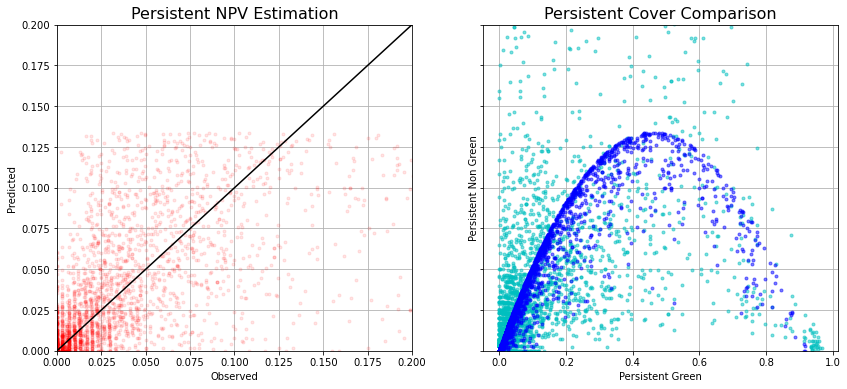

In [128]:

satPersistentNPV = (0.5798 * satPersistentGreen - 0.6282 * totalPVCover * satPersistentGreen) #Persistent 'dry'.


print ("Prediction RMSE = %f" % numpy.sqrt(numpy.mean((satPersistentNPV -persistentNPVFraction)**2)))
# Work out correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(persistentNPVFraction,satPersistentNPV)
print ("r-squared:", r_value**2)



# Initialise the 1 row 2 column plot
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6),sharey=True)
# Plot the three fractions
ax1.plot(persistentNPVFraction,satPersistentNPV, 'r.', alpha=0.1)
ax1.plot( [0,1], [0,1],'k-')
ax2.plot(satPersistentGreen,persistentNPVFraction, 'c.', alpha=0.5)
ax2.plot(satPersistentGreen,satPersistentNPV, 'b.', alpha=0.5)
# Grids
ax1.grid(True)
ax2.grid(True)
ax1.set_xlim([0,.2])
ax1.set_ylim([0,.2])

# Titles and Labels
ax1.set_title('Persistent NPV Estimation', fontsize=16)
ax2.set_title('Persistent Cover Comparison', fontsize=16)
ax1.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
ax2.set_xlabel('Persistent Green')
ax2.set_ylabel('Persistent Non Green')
f.savefig('coverUnderTreesCurrent.png', bbox_inches='tight', facecolor='white')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_45 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_46 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
..................................................

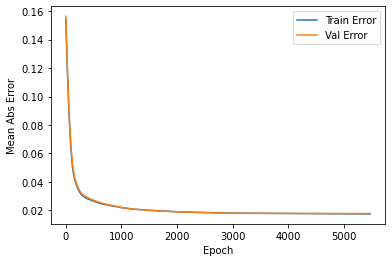

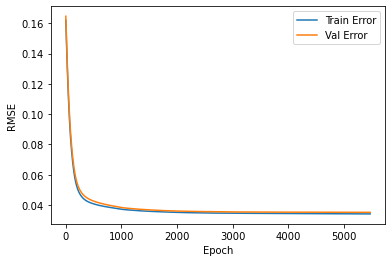

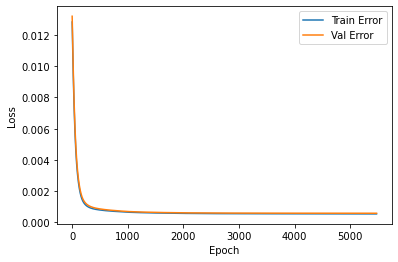

In [170]:
shuffleIDX = numpy.random.permutation(len(persistentNPVFraction))
X = numpy.transpose([totalPVCover,totalNPVCover,totalBareCover,satPersistentGreen])[shuffleIDX]
Y = persistentNPVFraction[shuffleIDX]





import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm

from tensorflow.keras import layers



model = keras.Sequential([
layers.Dense(16, activation='relu',kernel_constraint=max_norm(3),input_shape=[4]),
layers.Dense(16, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(16, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(1)
])

model.compile(loss=tf.keras.losses.Huber(delta=0.2),
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mean_absolute_error', 'mean_squared_error']) 

model.summary()


# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)



# Fit the Model np.hstack((full_labels,sampleWeights))
history = model.fit(X, Y,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=65536,
                    callbacks=[early_stop,PrintDot()])
print('\n')





#loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)


# Display the training history
def plot_history(history):
  hist = history.history
  epoch = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(epoch, hist['mean_absolute_error'],label='Train Error')
  plt.plot(epoch, hist['val_mean_absolute_error'],label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.plot(epoch, np.sqrt(hist['mean_squared_error']),label='Train Error')
  plt.plot(epoch, np.sqrt(hist['val_mean_squared_error']),label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(epoch, hist['loss'],label='Train Error')
  plt.plot(epoch, hist['val_loss'],label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [150]:
# Save the model
modelName = 'gcModel_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.hd5'
model.save(modelName,save_format='h5')
# Save a TFLite version
#converter = tf.lite.TFLiteConverter.from_keras_model_file(modelName)
#converter.experimental_new_converter = True
#tflite_model = converter.convert()
#open(modelName.replace('hd5','tflite'), "wb").write(tflite_model)

print('Saved: ',modelName)


Saved:  gcModel_202102081145.hd5


Prediction RMSE = 0.034701
r-squared: 0.43312054308196424


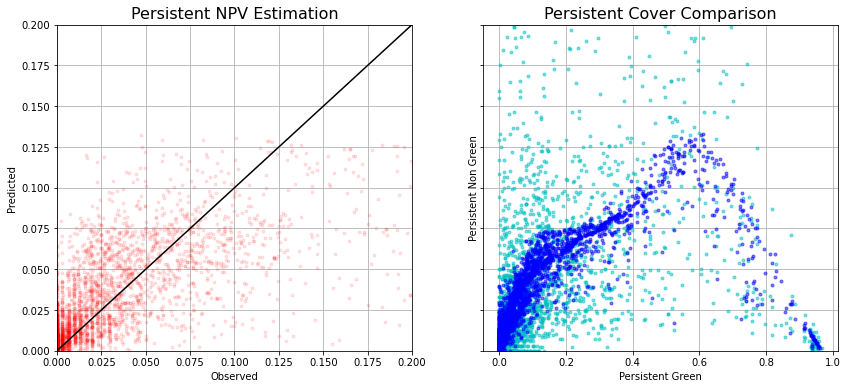

In [171]:
# Prediction
satPersistentNPV = model.predict(numpy.transpose([totalPVCover,totalNPVCover,totalBareCover,satPersistentGreen]))[:,0]
print ("Prediction RMSE = %f" % numpy.sqrt(numpy.mean((satPersistentNPV -persistentNPVFraction)**2)))
# Work out correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(persistentNPVFraction,satPersistentNPV)
print ("r-squared:", r_value**2)



# Initialise the 1 row 2 column plot
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6),sharey=True)
# Plot the three fractions
ax1.plot(persistentNPVFraction,satPersistentNPV, 'r.', alpha=0.1)
ax1.plot( [0,1], [0,1],'k-')
ax2.plot(satPersistentGreen,persistentNPVFraction, 'c.', alpha=0.5)
ax2.plot(satPersistentGreen,satPersistentNPV, 'b.', alpha=0.5)
# Grids
ax1.grid(True)
ax2.grid(True)
ax1.set_xlim([0,.2])
ax1.set_ylim([0,.2])

# Titles and Labels
ax1.set_title('Persistent NPV Estimation', fontsize=16)
ax2.set_title('Persistent Cover Comparison', fontsize=16)
ax1.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
ax2.set_xlabel('Persistent Green')
ax2.set_ylabel('Persistent Non Green')
f.savefig('coverUnderTreesTensorflow.png', bbox_inches='tight', facecolor='white')

## Plot the resulting correction for each fraction
  
  In the plot below the __darker__ colours represent the corrected data for each fraction

Green RMSE Error due to overstorey = 0.1733325893558769
Green RMSE Error after correction  = 0.012437552251950102 

NPV RMSE Error due to overstorey = 0.15391354195186702
NPV RMSE Error after correction  = 0.021347271501102452 

Bare RMSE Error due to overstorey = 0.043061155965290296
Bare RMSE Error after correction  = 0.013822367642280651 



Text(0, 0.5, 'Satellite')

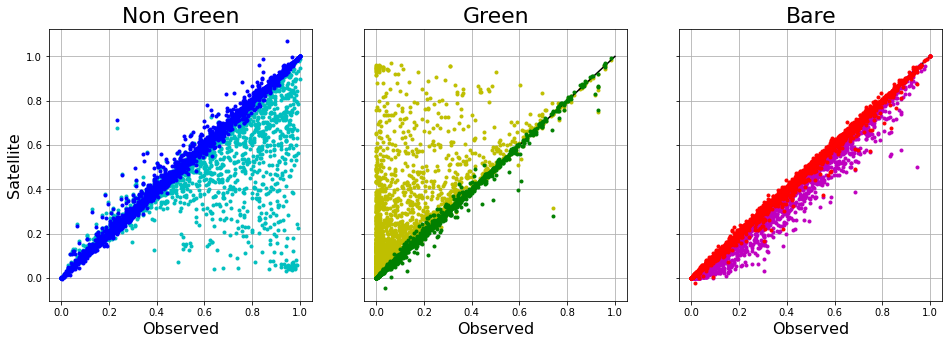

In [130]:
# This then, is the function for the gap fraction
gapFractionEstimate=1.0- satPersistentGreen-satPersistentNPV

# Correct the Green Ground Fraction
predictedGroundGreen=(totalPVCover-satPersistentGreen)/gapFractionEstimate
# Correct the NonGreen Ground Fraction
predictedGroundNPV=(totalNPVCover-satPersistentNPV)/gapFractionEstimate
# Correct the Bare Ground Fraction
predictedGroundBare=totalBareCover/gapFractionEstimate

# Print RMSE Errors
print ("Green RMSE Error due to overstorey =", numpy.sqrt(numpy.mean((groundPVCover-totalPVCover)**2)))
print ("Green RMSE Error after correction  =", numpy.sqrt(numpy.mean((groundPVCover-predictedGroundGreen)**2)),'\n')


# Print RMSE Errors
print ("NPV RMSE Error due to overstorey =", numpy.sqrt(numpy.mean((groundNPVCover-totalNPVCover)**2)))
print ("NPV RMSE Error after correction  =", numpy.sqrt(numpy.mean((groundNPVCover-predictedGroundNPV)**2)),'\n')


# Print RMSE Errors
print ("Bare RMSE Error due to overstorey =", numpy.sqrt(numpy.mean((groundBareCover-totalBareCover)**2)))
print ("Bare RMSE Error after correction  =", numpy.sqrt(numpy.mean((groundBareCover-predictedGroundBare)**2)),'\n')

# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5),sharey=True)
# Plot the three fractions
ax1.plot(groundNPVCover,totalNPVCover, 'c.',[0,1], [0,1],'k-',groundNPVCover,predictedGroundNPV,'b.')
ax2.plot(groundPVCover,totalPVCover, 'y.',[0,1], [0,1],'k-',groundPVCover,predictedGroundGreen,'g.')
ax3.plot(groundBareCover,totalBareCover, 'm.',[0,1], [0,1],'k-',groundBareCover,predictedGroundBare,'r.')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Non Green', fontsize=22)
ax2.set_title('Green', fontsize=22)
ax3.set_title('Bare', fontsize=22)
ax1.set_xlabel('Observed', fontsize=16)
ax2.set_xlabel('Observed', fontsize=16)
ax3.set_xlabel('Observed', fontsize=16)
ax1.set_ylabel('Satellite', fontsize=16)

#f.savefig('coverUnderTrees.png', bbox_inches='tight')


In [132]:
tf.lite.TFLiteConverter?

## Ground Litter Fraction


1.0363389166666666 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(LassoLarsCV(input_matrix, normalize=True), bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=14, min_samples_split=3, n_estimators=100)
Prediction RMSE = 0.107211
r-squared: 0.7355241284482881


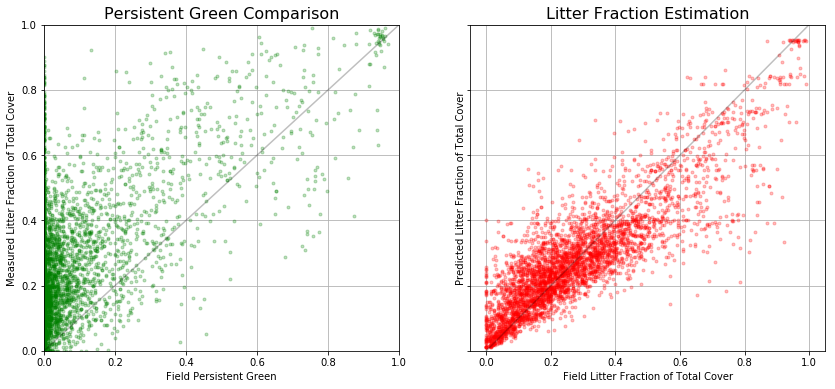

In [5]:

optTime = 10
numCores = 32
#score = 'r2'
score = 'neg_mean_squared_error'


X = numpy.transpose([totalPVCover,totalNPVCover,totalBareCover,satPersistentGreen])
y = groundLitterFraction

tpot = TPOTRegressor(max_time_mins=optTime, max_eval_time_mins=1, population_size=100, verbosity=2, cv=10, n_jobs = numCores, scoring=score)
tpot.fit(X, y)

# Prediction
satLitterFraction = tpot.predict(X)
print ("Prediction RMSE = %f" % numpy.sqrt(numpy.mean((satLitterFraction -groundLitterFraction)**2)))
# Work out correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(groundLitterFraction,satLitterFraction)
print ("r-squared:", r_value**2)



# Initialise the 1 row 2 column plot
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6),sharey=True)
# Plot the three fractions
ax2.plot(groundLitterFraction,satLitterFraction, 'r.', [0,1], [0,1],'k-',alpha=0.25)
ax1.plot(satPersistentGreen,groundLitterFraction, 'g.', [0,1], [0,1],'k-',,alpha=0.25)
# Grids
ax1.grid(True)
ax2.grid(True)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])

# Titles and Labels
ax2.set_title('Litter Fraction Estimation', fontsize=16)
ax1.set_title('Persistent Green Comparison', fontsize=16)
ax2.set_xlabel('Field Litter Fraction of Total Cover')
ax2.set_ylabel('Predicted Litter Fraction of Total Cover')
ax1.set_xlabel('Field Persistent Green')
ax1.set_ylabel('Measured Litter Fraction of Total Cover')
f.savefig('litterFraction.png', bbox_inches='tight')